# **TÉCNICAS DE SUAVIZADO**

Análisis del comportamiento de la serie de tiempo de la demanda de electricidad desde 1980 a 1995 en Australia. Observando la tendencia y estacionalidad realizando una descomposición de la serie, aplicando una prueba de hipótesis para identificar si es estacionaria o no estacionaria, observar la autocorrelacón de los coeficientes y finalmente generar las técnicas de suavizado con sus respectivos factores.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Autocorrelacion
# ==============================================================================
import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sm

# warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")

# Modelos
# ==============================================================================
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Contraste de hipótesis
# ==============================================================================
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts
from scipy.stats import chi2


In [84]:
df = pd.read_csv('/content/drive/MyDrive/Portafolio/PYTHON/Bases/Demanda_electricidad_mensual.csv')
df.head()

,Fecha,Demanda(GWh)
0,Ene-80,7366
1,Feb-80,7414
2,Mar-80,7824
3,Abr-80,7524
4,May-80,8279


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Fecha         188 non-null    object
 1   Demanda(GWh)  188 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ KB


In [3]:
# Crear un diccionario de mapeo de meses
meses = {
    "Ene": "01", "Feb": "02", "Mar": "03", "Abr": "04",
    "May": "05", "Jun": "06", "Jul": "07", "Ago": "08",
    "Sep": "09", "Set": "09", "Oct": "10", "Nov": "11", "Dic": "12"
}

# Suponiendo que tu DataFrame se llama df y la columna de fechas se llama 'Fecha'
df['Fecha'] = df['Fecha'].apply(lambda x: x.replace(x[:3], meses[x[:3]]))
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%m-%y')

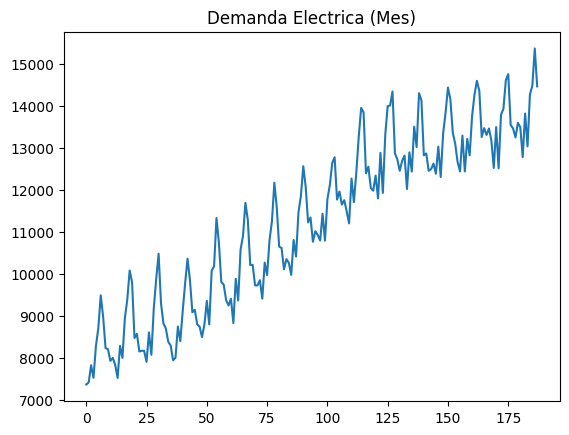

In [4]:
# Plot
plt.plot(df['Demanda(GWh)'])
plt.title("Demanda Electrica (Mes)")
plt.show()

## **Prueba de Dickey-Fuller**

In [5]:
# Serie de tiempo
serie_tiempo = df['Demanda(GWh)']

# Realizar la prueba de Dickey-Fuller aumentada
result = sts.adfuller(serie_tiempo)

# Mostrar los resultados
print('Estadística de prueba:', result[0])
print('Valor p:', result[1])
print('Valores críticos:', result[4])
print('Resultados de la prueba:')
print('La serie es estacionaria' if result[1] < 0.05 else 'La serie no es estacionaria')

Estadística de prueba: -1.1172932759845324
Valor p: 0.7081265085335563
Valores críticos: {'1%': -3.4687256239864017, '5%': -2.8783961376954363, '10%': -2.57575634100705}
Resultados de la prueba:
La serie no es estacionaria


## **Descomposición Estacional de la Serie de Tiempo**

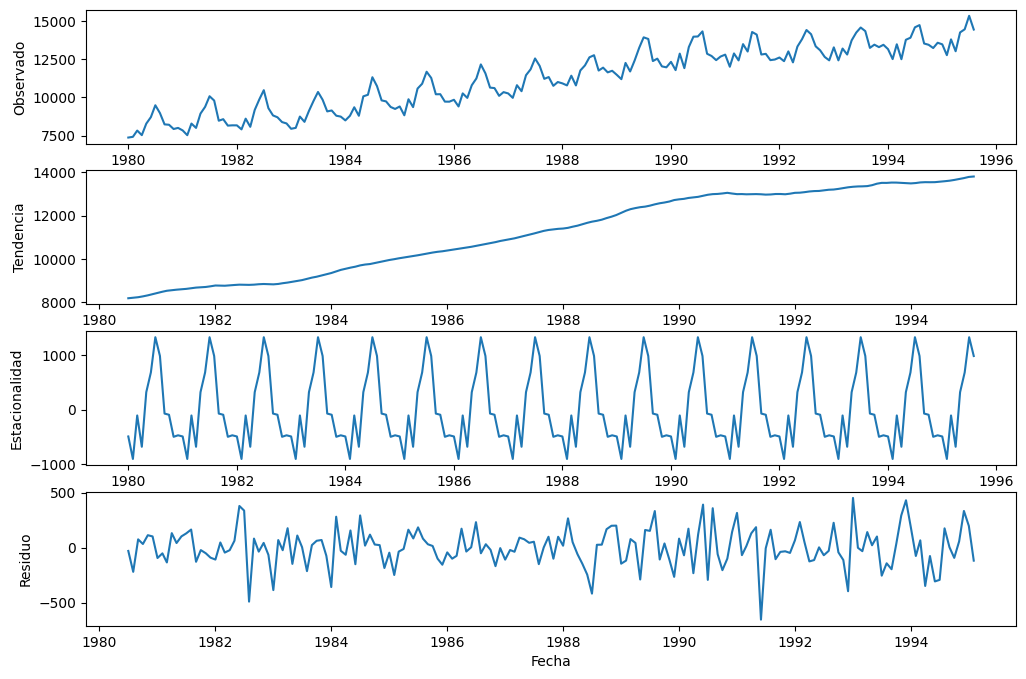

In [6]:
# Descomponer la serie temporal en componentes de tendencia

from statsmodels.tsa.seasonal import seasonal_decompose

# Crear una serie temporal con las ventas totales
sales_series = df.groupby('Fecha')['Demanda(GWh)'].sum()

# Realizar el análisis de estacionalidad
result1 = seasonal_decompose(sales_series, model='additive', period=12)

# Graficar los componentes
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(result1.observed)
plt.ylabel('Observado')
plt.subplot(412)
plt.plot(result1.trend)
plt.ylabel('Tendencia')
plt.subplot(413)
plt.plot(result1.seasonal)
plt.ylabel('Estacionalidad')
plt.subplot(414)
plt.plot(result1.resid)
plt.ylabel('Residuo')
plt.xlabel('Fecha')
plt.show()

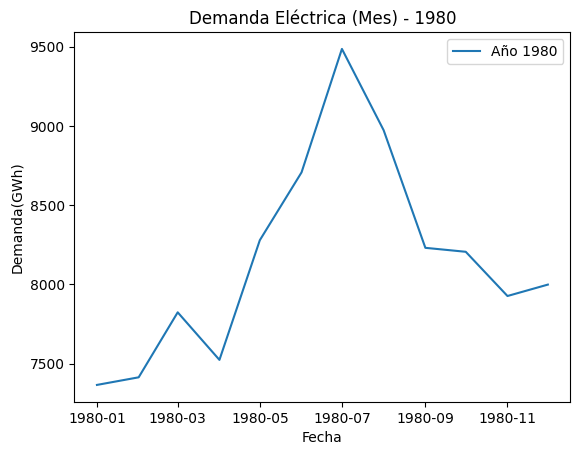

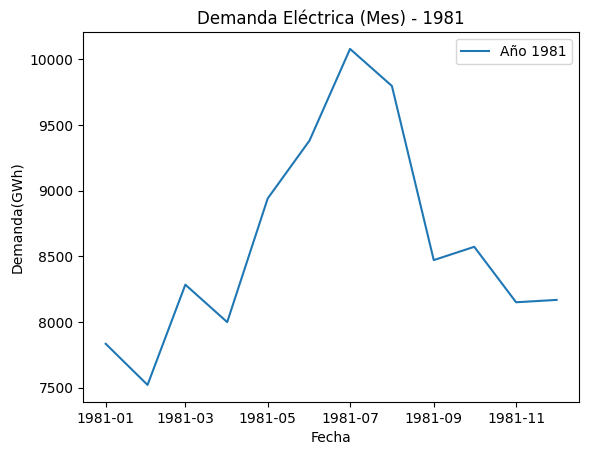

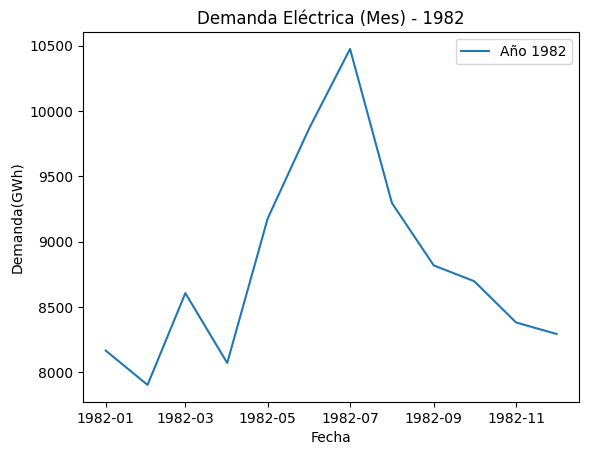

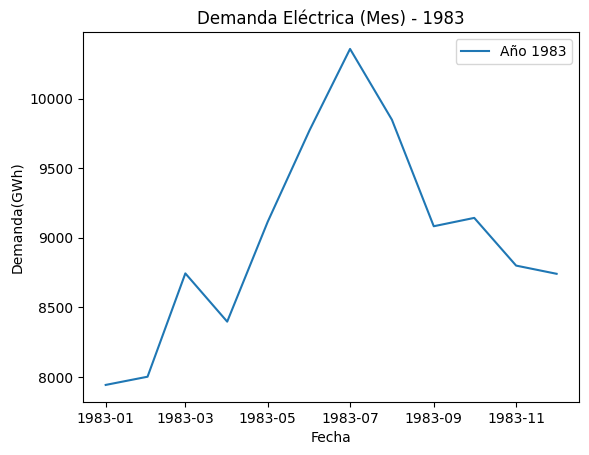

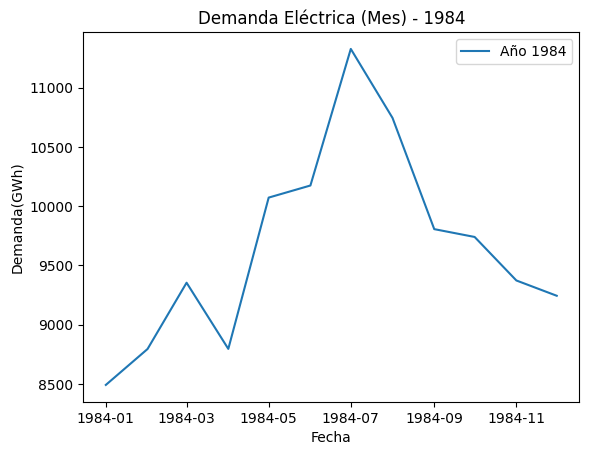

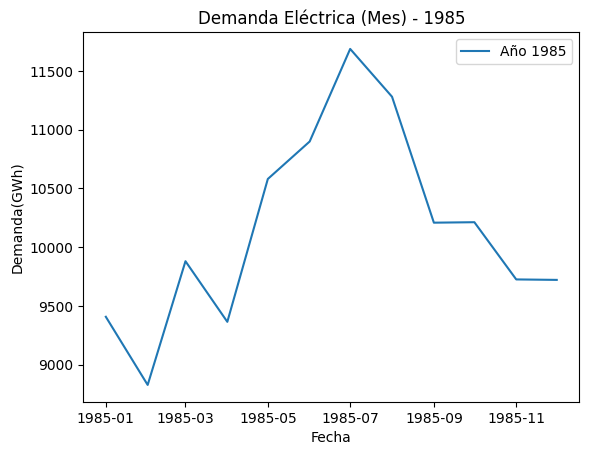

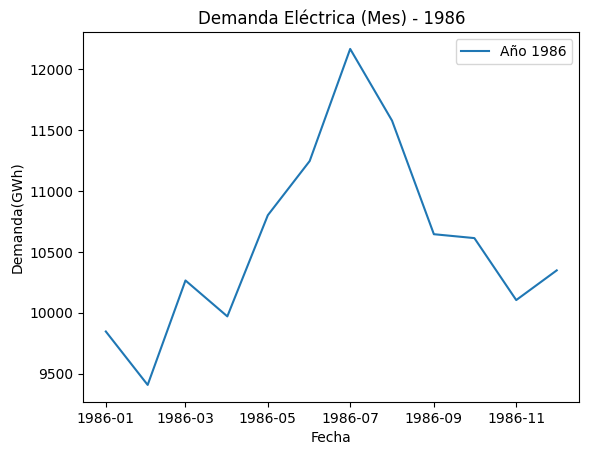

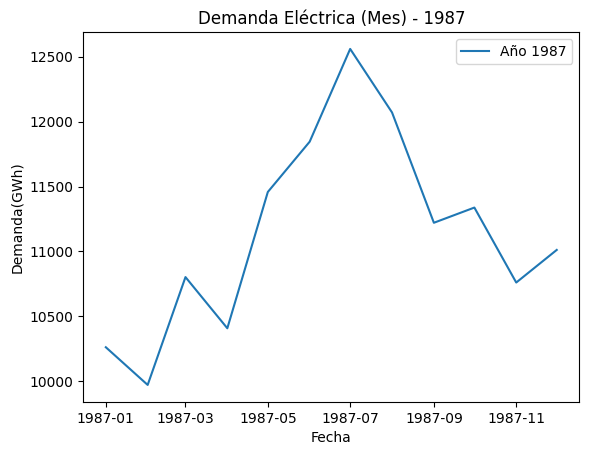

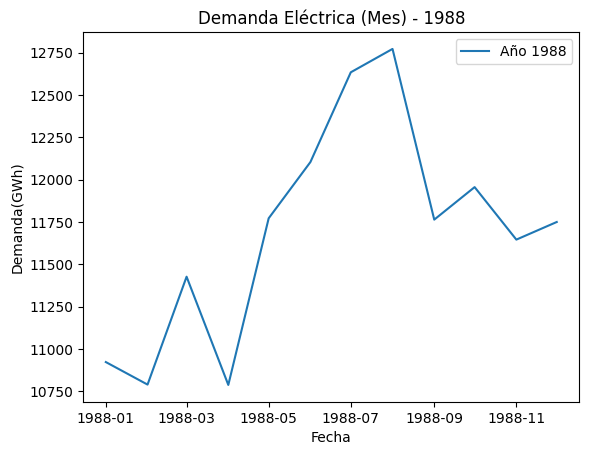

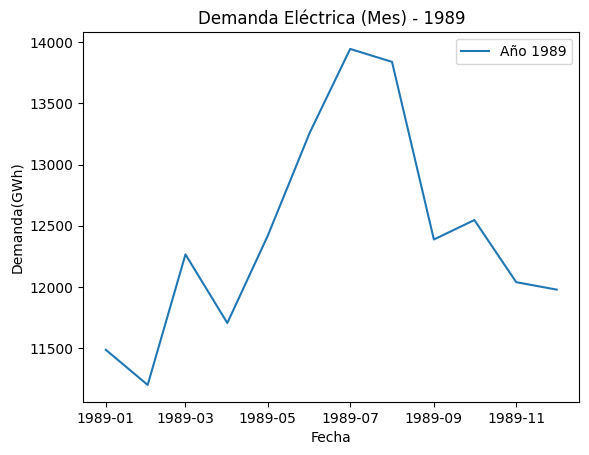

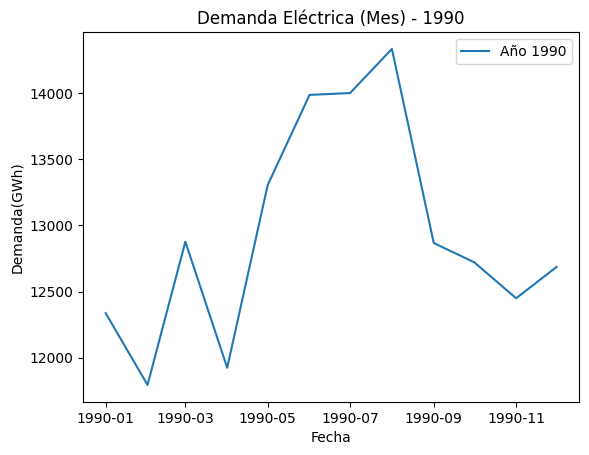

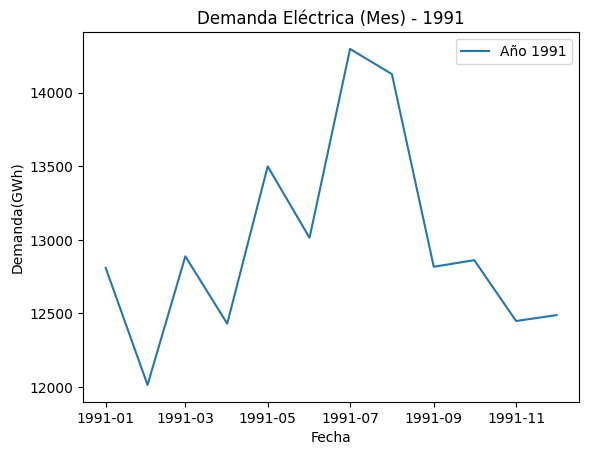

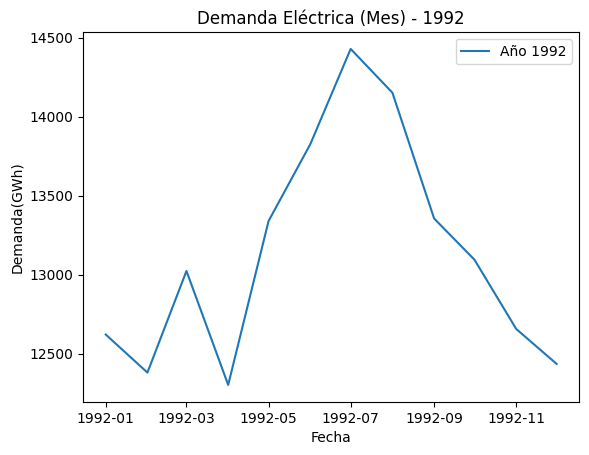

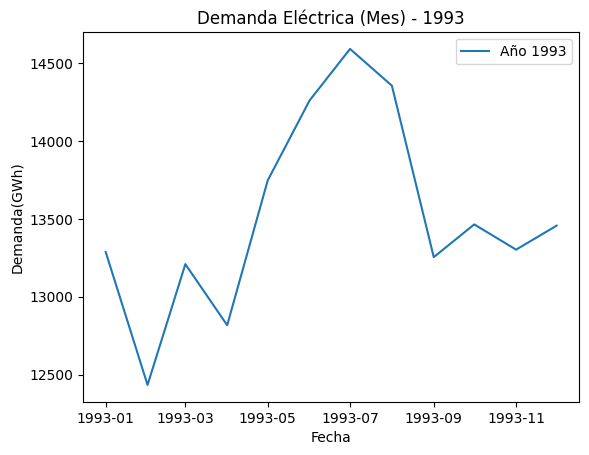

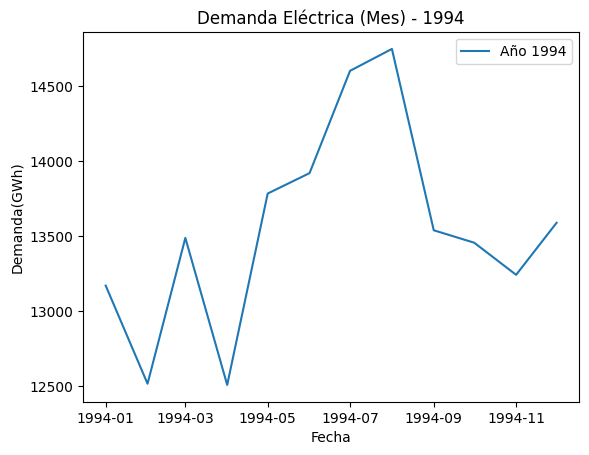

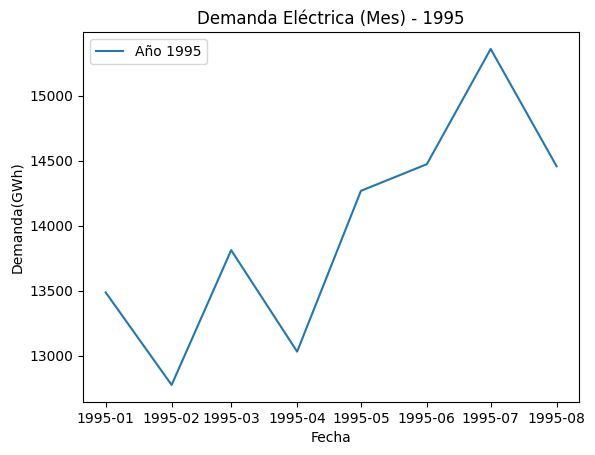

In [5]:
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Crear una columna de año
df['Año'] = df['Fecha'].dt.year

# Obtener los años únicos
anios_unicos = df['Año'].unique()

# Crear un gráfico para cada año
for anio in anios_unicos:
    df_anio = df[df['Año'] == anio]
    plt.plot(df_anio['Fecha'], df_anio['Demanda(GWh)'], label=f'Año {anio}')
    plt.title(f"Demanda Eléctrica (Mes) - {anio}")
    plt.xlabel('Fecha')
    plt.ylabel('Demanda(GWh)')
    plt.legend()
    plt.show()


Se puede observar que la demanda de la electricidad presenta una tendencia desde lo 80's al aumento, como se puede observar en la segunda figura (Tendencia), existe un comportamiento lineal que puede responder a diferentes factores externos como el consumo per capita por procesos de industrialización, tecnologías, cambios de estaciones, etc.

Además, se puede determinar que existe una estacionalidad para la serie analizada, esto se produce en determinadas ventanas de tiempo particularmente entre junio a agosto que son temporadas con temperaturas bajas (Invierno) en este territorio, por lo que se puede relacionar el aumento del consumo debido al uso de aparatos/sistemas de calefacción en hogares y edificios.

## **Autocorrelación**

ACF mide la correlación entre una variable y sus valores rezagados. Se utiliza para identificar si existe una dependencia temporal entre los valores de la serie.

En la grafica la zona azul (area de significación) logra medir si las autocorrelaciones son significativamentes diferentes de cero, es decir, permiten medir si los valores previos contienen mucha información acerca del próximo valor. Esta franja va en considerable aumento ya que entre mayor tiempo se considere se reduce la probabilidad de que los valores pasados sean útiles para predecir.

*Nota: Se espera que el ruido blanco no tenga autocorrelación con sus valores, por lo que siempre estarán dentro de la zona azul.*

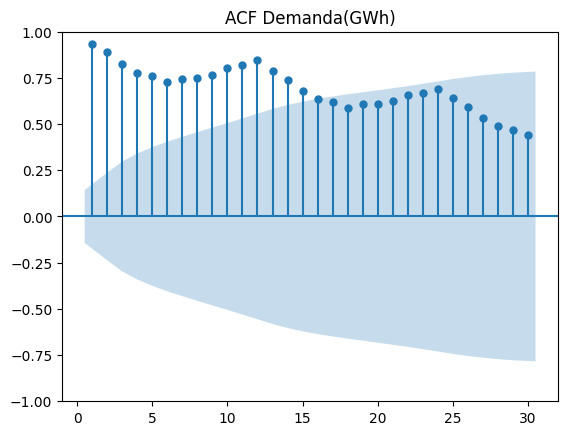

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Demanda(GWh)'], lags=30, zero=False) # lags = retrasos
plt.title('ACF Demanda(GWh)', size=12)
plt.show()

## **Autocorrelación Parcial**

PACF mide la correlación entre una variable y sus valores rezagados después de eliminar el efecto de otros retardos. Este ayuda a determinar el desfase exacto tras el cual cesan las autocorrelaciones, lo que es crucial para determinar el orden del modelo AR.

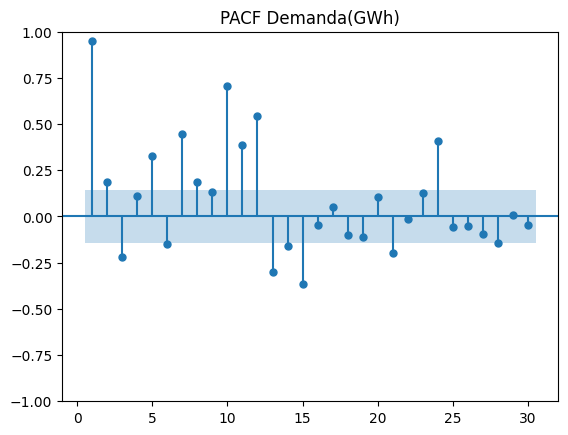

In [15]:
sm.graphics.tsa.plot_pacf(df['Demanda(GWh)'], lags=30, zero=False, method='ols') # minimos cuadrados ordinarios
plt.title('PACF Demanda(GWh)', size=12)
plt.show()

## **SMA: Media movil simple. Factor de suavizado ALFA**

Calcula el promedio de los datos en un período de tiempo específico. Esta técnica es útil para eliminar el ruido y observar tendencias subyacentes en los datos de una serie temporal.

In [7]:
series1 = pd.Series(data=df['Demanda(GWh)'].values, index=pd.to_datetime(df['Fecha'], format='%m-%Y'), name='Demanda(GWh)')

# Convertir la Serie vta en un DataFrame
series1 = pd.DataFrame(series1)

# Verificar el DataFrame df
print(series1)


            Demanda(GWh)
Fecha                   
1980-01-01          7366
1980-02-01          7414
1980-03-01          7824
1980-04-01          7524
1980-05-01          8279
...                  ...
1995-04-01         13032
1995-05-01         14268
1995-06-01         14473
1995-07-01         15359
1995-08-01         14457

[188 rows x 1 columns]


In [8]:
series1['2-meses'] = series1['Demanda(GWh)'].rolling(window=2).mean()
series1['3-meses'] = series1['Demanda(GWh)'].rolling(window=3).mean()
series1['6-meses'] = series1['Demanda(GWh)'].rolling(window=6).mean()

In [9]:
series1.head()

,Demanda(GWh),2-meses,3-meses,6-meses
Fecha,,,,
1980-01-01,7366,NaN,NaN,NaN
1980-02-01,7414,7390.0,NaN,NaN
1980-03-01,7824,7619.0,7534.666667,NaN
1980-04-01,7524,7674.0,7587.333333,NaN
1980-05-01,8279,7901.5,7875.666667,NaN


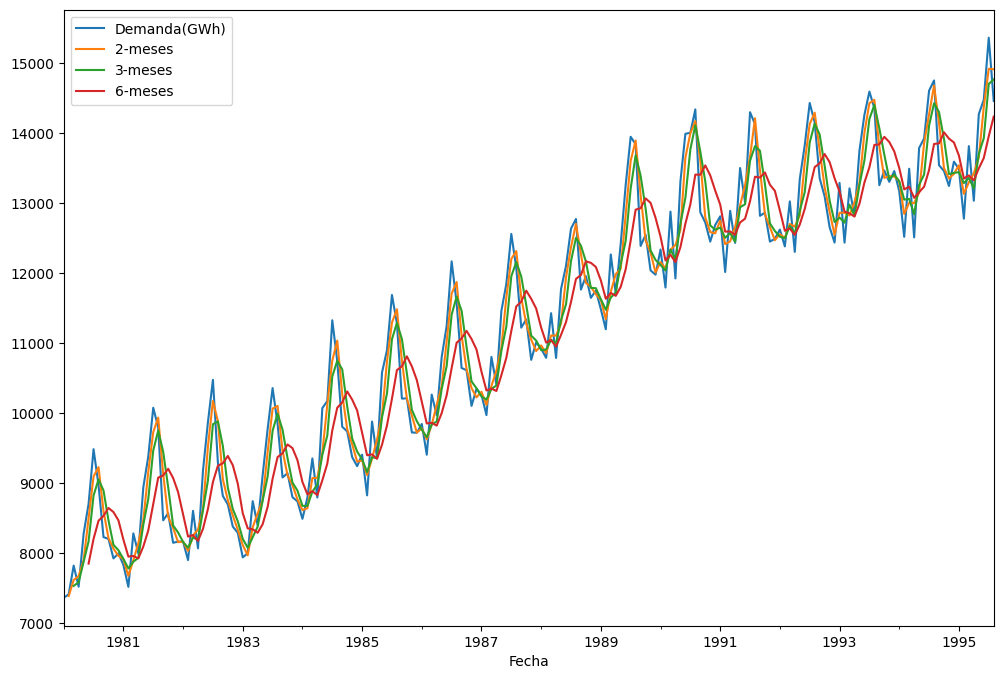

In [10]:
series1.plot(figsize=(12,8));

In [11]:
# observar el MSE de cada ventada de tiempo
mse_2_meses = mean_squared_error(series1['Demanda(GWh)'][1:], series1['2-meses'][1:])
mse_3_meses = mean_squared_error(series1['Demanda(GWh)'][2:], series1['3-meses'][2:])
mse_6_meses = mean_squared_error(series1['Demanda(GWh)'][5:], series1['6-meses'][5:])

print(f"MSE 2 meses: {mse_2_meses}")
print(f"MSE 3 meses: {mse_3_meses}")
print(f"MSE 6 meses: {mse_6_meses}")

MSE 2 meses: 102396.98796791444
MSE 3 meses: 191169.8321385902
MSE 6 meses: 500909.9045233759


Como se puede observar en la gráfica y en la métrica MSE la ventana de tiempo de 2 y 3 meses siguen mejor el comportamiento de la demanda de la electricidad en Australia, esto sucede debido a que los datos con regazo de 2 y 3 son aquellos que tienen mayor autocorrelación con los datos presentes.

## **EWMA: Promedio movil ponderado exponencialmente. Factor de suavizado ALFA**

El EWMA da más peso a los datos más recientes, lo que lo hace más sensible a los cambios recientes en la serie temporal.

In [18]:
series1['ewma2m'] = series1['Demanda(GWh)'].ewm(span=2, adjust=False).mean()
series1['ewma3m'] = series1['Demanda(GWh)'].ewm(span=3, adjust=False).mean()
series1['ewma4m'] = series1['Demanda(GWh)'].ewm(span=4, adjust=False).mean()

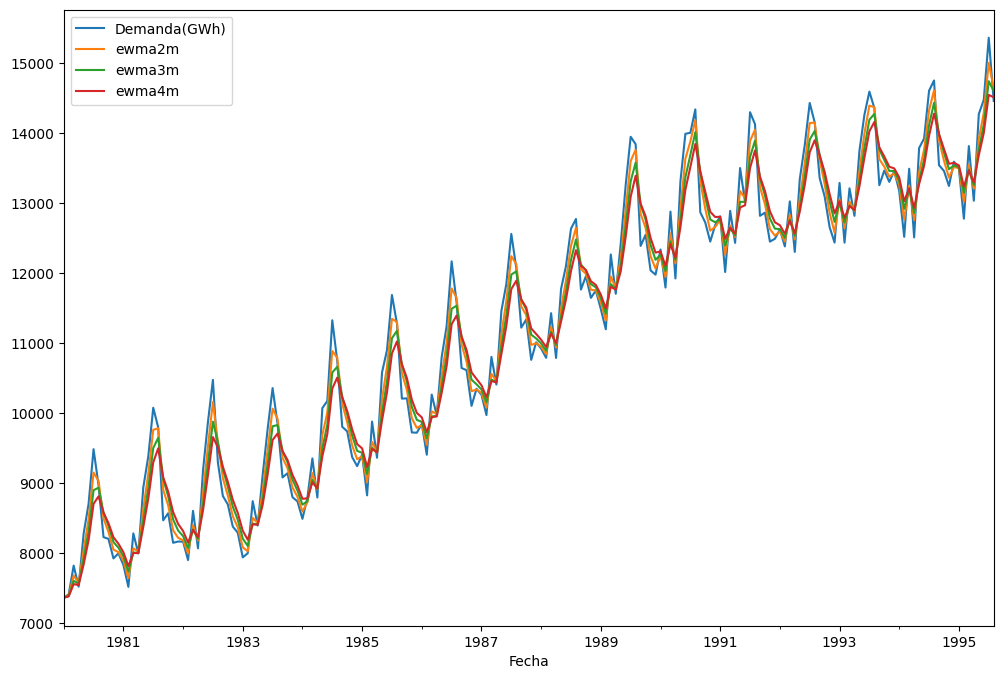

In [19]:
series1[['Demanda(GWh)','ewma2m','ewma3m','ewma4m']].plot(figsize=(12,8));

In [21]:
# observar el MSE de cada ventada de tiempo
ewma_mse_2_meses = mean_squared_error(series1['Demanda(GWh)'][1:], series1['ewma2m'][1:])
ewma_mse_3_meses = mean_squared_error(series1['Demanda(GWh)'][2:], series1['ewma3m'][2:])
ewma_mse_4_meses = mean_squared_error(series1['Demanda(GWh)'][5:], series1['ewma4m'][5:])

print(f"MSE 2 meses: {ewma_mse_2_meses}")
print(f"MSE 3 meses: {ewma_mse_3_meses}")
print(f"MSE 6 meses: {ewma_mse_4_meses}")

MSE 2 meses: 45902.47006750806
MSE 3 meses: 114376.40457733544
MSE 6 meses: 178893.02388717502


## **SMA vs EWMA**

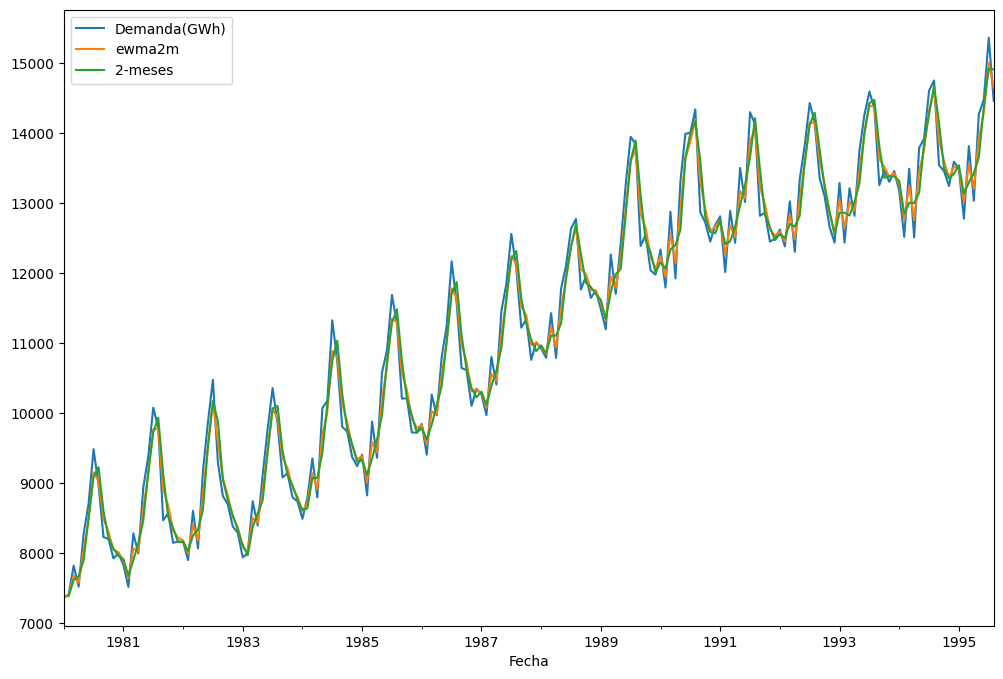

In [23]:
series1[['Demanda(GWh)','ewma2m','2-meses']].plot(figsize=(12,8));

Empleando el indicador del error cuadratico se puede establecer que el promedio movil ponderado exponencial con rezago igual a 2 meses es aquel que logra capturar el comportamiento de los ultimos periodos de la serie y por ende reconoce de mejor forma la tendencia de los valores.

## **Metodo Holt-Winters**

*    **Suavizado exponencial doble**: Metodo de Holt, aborda la tendencia. Factor de suavizado BETA.

*    **Suavizado exponencial triple**: Metodo de Holt-Winter, aborda la tendencia y la estacionalidad. Factor de suavizado GAMMA.

In [24]:
series2 = pd.Series(data=df['Demanda(GWh)'].values, index=pd.to_datetime(df['Fecha'], format='%m-%Y'), name='Demanda(GWh)')

# Convertir la Serie vta en un DataFrame
series2 = pd.DataFrame(series2)

# Verificar el DataFrame df
print(series2)

            Demanda(GWh)
Fecha                   
1980-01-01          7366
1980-02-01          7414
1980-03-01          7824
1980-04-01          7524
1980-05-01          8279
...                  ...
1995-04-01         13032
1995-05-01         14268
1995-06-01         14473
1995-07-01         15359
1995-08-01         14457

[188 rows x 1 columns]


In [25]:
series2.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Fecha', length=188, freq=None)

In [26]:
series2.index.freq='MS'
series2.index

DatetimeIndex(['1980-01-01', '1980-02-01', '1980-03-01', '1980-04-01',
               '1980-05-01', '1980-06-01', '1980-07-01', '1980-08-01',
               '1980-09-01', '1980-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Fecha', length=188, freq='MS')

In [27]:
series2.head()

,Demanda(GWh)
Fecha,
1980-01-01,7366
1980-02-01,7414
1980-03-01,7824
1980-04-01,7524
1980-05-01,8279


### *Suavizado exponencial simple*

Es una técnica de suavizamiento utilizada en series temporales para nivelar fluctuaciones y resaltar tendencias. Se usa para series temporales sin tendencia ni estacionalidad

In [28]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 3
alpha = 2 / (span+1)

series2['ewma3m'] = series2['Demanda(GWh)'].ewm(span=3, adjust=False).mean()
series2['SES3'] = SimpleExpSmoothing(series2['Demanda(GWh)']).fit(smoothing_level=alpha, optimized=False).fittedvalues.shift(-1)
series2.head()

,Demanda(GWh),ewma3m,SES3
Fecha,,,
1980-01-01,7366,7366.00,7366.00
1980-02-01,7414,7390.00,7390.00
1980-03-01,7824,7607.00,7607.00
1980-04-01,7524,7565.50,7565.50
1980-05-01,8279,7922.25,7922.25


### *suavizado exponencial doble - Método de Holt*

*   Método aditivo: comportamiento lineal, la tendencia de la serie temporal es más o menos constante a lo largo del tiempo y no muestra un patrón estacional.

*   Método multiplicativo: comportamiento exponencial, la tendencia de la serie temporal varía con el tiempo y/o muestra un patrón estacional.

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series2['SED3_add'] = ExponentialSmoothing(series2['Demanda(GWh)'], trend='add').fit().fittedvalues.shift(-1)
series2.head()

,Demanda(GWh),ewma3m,SES3,SED3_add
Fecha,,,,
1980-01-01,7366,7366.00,7366.00,7537.954548
1980-02-01,7414,7390.00,7390.00,7580.708971
1980-03-01,7824,7607.00,7607.00,7941.478803
1980-04-01,7524,7565.50,7565.50,7730.435194
1980-05-01,8279,7922.25,7922.25,8354.226902


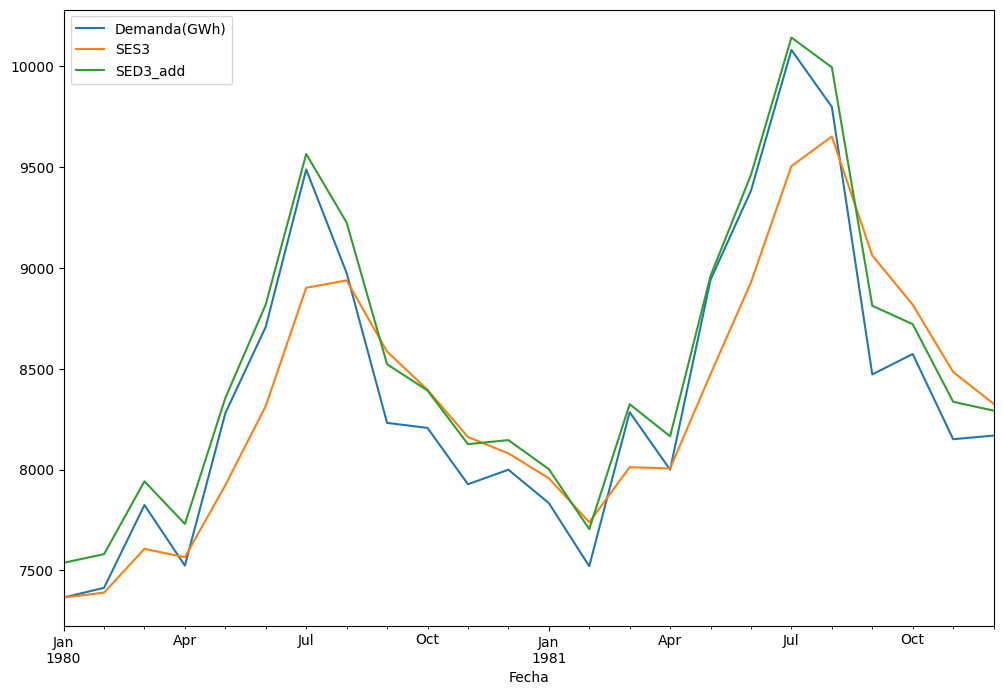

In [30]:
series2[['Demanda(GWh)','SES3','SED3_add']].iloc[:24].plot(figsize=(12,8)).autoscale(axis='x',tight=True)

In [31]:
series2['SED3_mul'] = ExponentialSmoothing(series2['Demanda(GWh)'], trend='mul').fit().fittedvalues.shift(-1)
series2.head()

,Demanda(GWh),ewma3m,SES3,SED3_add,SED3_mul
Fecha,,,,,
1980-01-01,7366,7366.00,7366.00,7537.954548,7538.583780
1980-02-01,7414,7390.00,7390.00,7580.708971,7582.330599
1980-03-01,7824,7607.00,7607.00,7941.478803,7950.628529
1980-04-01,7524,7565.50,7565.50,7730.435194,7736.518285
1980-05-01,8279,7922.25,7922.25,8354.226902,8372.692299


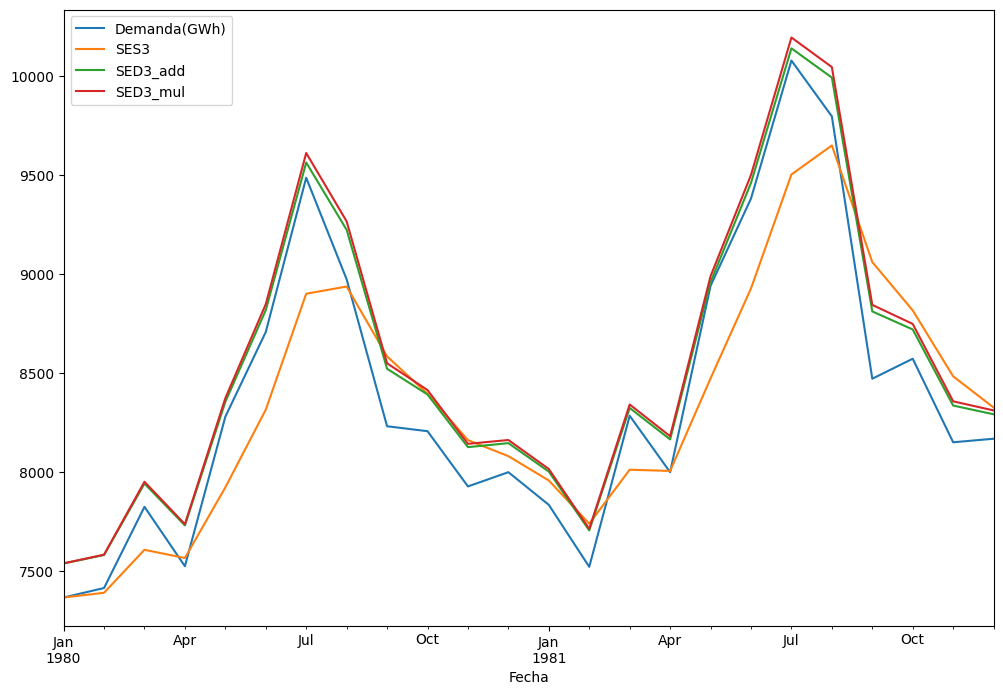

In [32]:
series2[['Demanda(GWh)','SES3','SED3_add','SED3_mul']].iloc[:24].plot(figsize=(12,8)).autoscale(axis='x',tight=True)

### *suavizado exponencial triple - Método de Holt Winters*

In [33]:
series2['SET3_add'] = ExponentialSmoothing(series2['Demanda(GWh)'], trend='add', seasonal='add',seasonal_periods=12).fit().fittedvalues
series2.head()

,Demanda(GWh),ewma3m,SES3,SED3_add,SED3_mul,SET3_add
Fecha,,,,,,
1980-01-01,7366,7366.00,7366.00,7537.954548,7538.583780,7426.789330
1980-02-01,7414,7390.00,7390.00,7580.708971,7582.330599,7233.633280
1980-03-01,7824,7607.00,7607.00,7941.478803,7950.628529,7994.666119
1980-04-01,7524,7565.50,7565.50,7730.435194,7736.518285,7525.391492
1980-05-01,8279,7922.25,7922.25,8354.226902,8372.692299,8501.000636


In [34]:
series2['SET3_mul'] = ExponentialSmoothing(series2['Demanda(GWh)'], trend='mul', seasonal='mul',seasonal_periods=12).fit().fittedvalues
series2.head()

,Demanda(GWh),ewma3m,SES3,SED3_add,SED3_mul,SET3_add,SET3_mul
Fecha,,,,,,,
1980-01-01,7366,7366.00,7366.00,7537.954548,7538.583780,7426.789330,7483.407286
1980-02-01,7414,7390.00,7390.00,7580.708971,7582.330599,7233.633280,7408.631218
1980-03-01,7824,7607.00,7607.00,7941.478803,7950.628529,7994.666119,8061.762285
1980-04-01,7524,7565.50,7565.50,7730.435194,7736.518285,7525.391492,7627.224926
1980-05-01,8279,7922.25,7922.25,8354.226902,8372.692299,8501.000636,8536.397551


<Axes: xlabel='Fecha'>

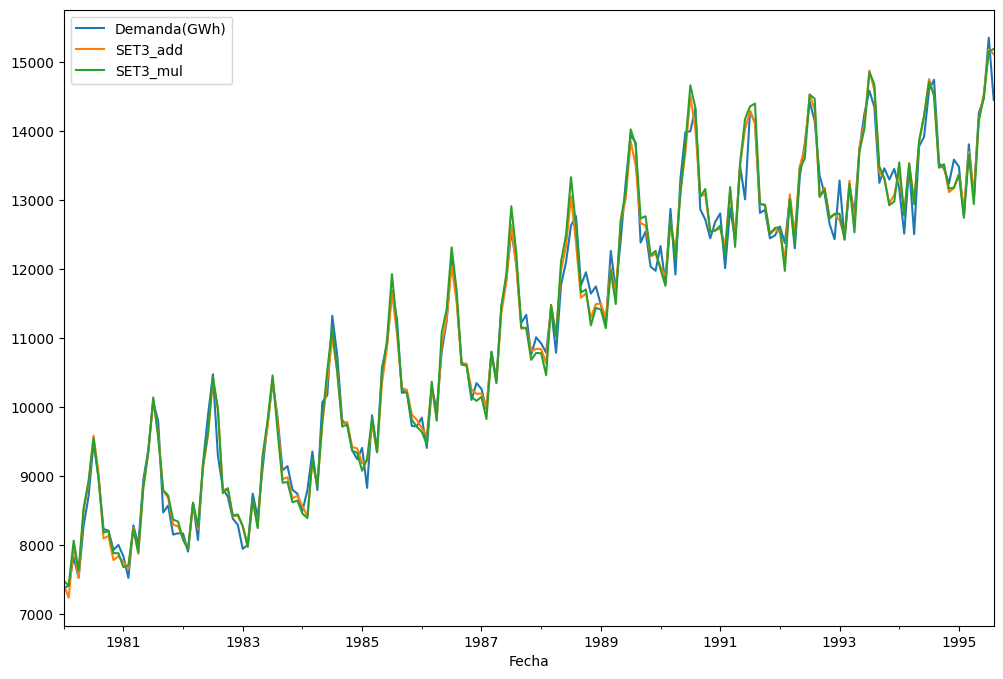

In [35]:
series2[['Demanda(GWh)','SET3_add','SET3_mul']].plot(figsize=(12,8))

<Axes: xlabel='Fecha'>

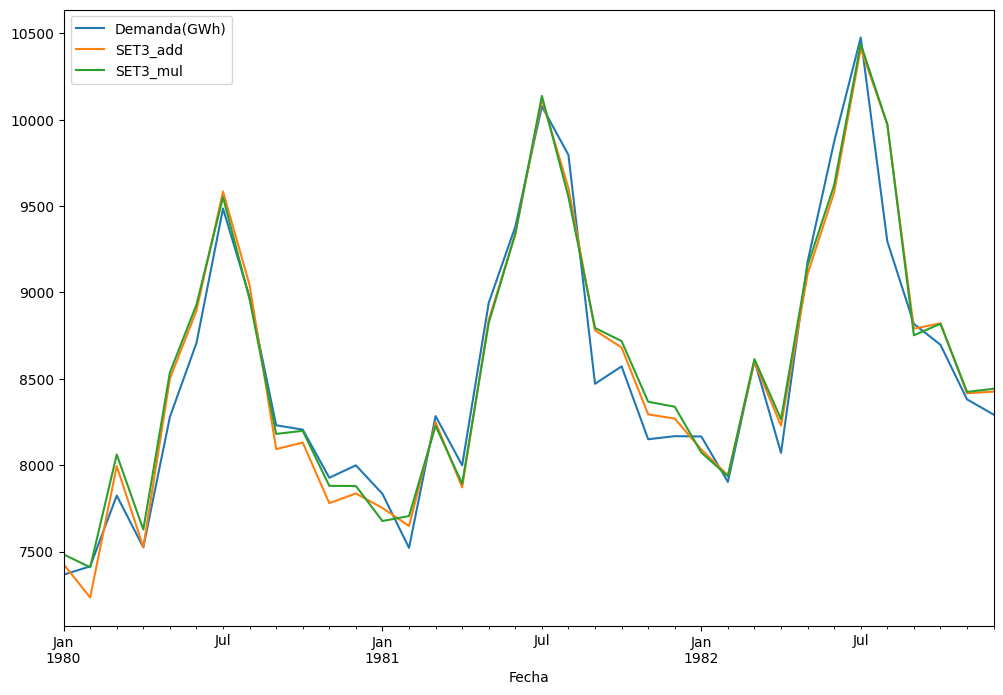

In [36]:
series2[['Demanda(GWh)','SET3_add','SET3_mul']].iloc[:36].plot(figsize=(12,8))

*Pronóstico de la demanda de electricidad a 36 meses*

In [37]:
model_add = ExponentialSmoothing(series2['Demanda(GWh)'], trend='add', seasonal='add',seasonal_periods=12).fit()

In [38]:
model_mul = ExponentialSmoothing(series2['Demanda(GWh)'], trend='mul', seasonal='mul',seasonal_periods=12).fit()

In [39]:
# Generar pronósticos a 36 meses
forecast_add = model_add.forecast(36)
forecast_mul = model_mul.forecast(36)

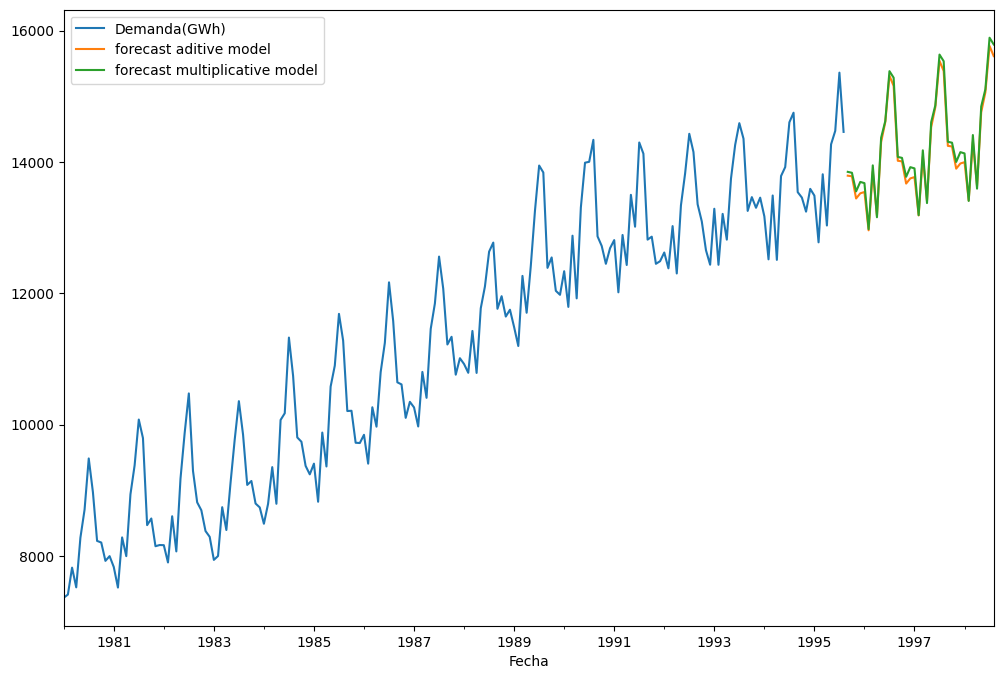

In [40]:
# graficar pronósticos
series2['Demanda(GWh)'].plot(figsize=(12,8))
forecast_add.plot(label='forecast aditive model')
forecast_mul.plot(label='forecast multiplicative model');
plt.legend(loc='upper left')

MSE para SES, SED multiplicativo y SET multiplicativo

In [70]:
SES_mse = mean_squared_error(series2['Demanda(GWh)'][:-1], series2['SES3'][:-1])
SED3_mse_mul = mean_squared_error(series2['Demanda(GWh)'][:-1], series2['SED3_mul'][:-1])
SET3_mse_mul = mean_squared_error(series2['Demanda(GWh)'][:-1], series2['SET3_mul'][:-1])
SED3_mse_add = mean_squared_error(series2['Demanda(GWh)'][:-1], series2['SED3_add'][:-1])
SET3_mse_add = mean_squared_error(series2['Demanda(GWh)'][:-1], series2['SET3_add'][:-1])


print(f"MSE SES: {SES_mse}")
print(f"MSE SED_mul: {SED3_mse_mul}")
print(f"MSE SET_mul: {SET3_mse_mul}")
print(f"MSE SED_add: {SED3_mse_add}")
print(f"MSE SET_add: {SET3_mse_add}")

MSE SES: 113662.19521244983
MSE SED_mul: 18860.39088637727
MSE SET_mul: 53008.40807345229
MSE SED_add: 13955.694976822211
MSE SET_add: 42926.78903619173


#### **Analizar modelos y resultados**

Considerando que la serie de tiempo posee estacionalidad y tendencia se decide optar por el método Holt-Winter o de suavizado exponencial triple, generando el pronóstico con el método aditivo y el multiplicativo logrando tener como resultado que el primero es aquel que mejor poder de predicción tiene de acuerdo a las métricas, sin embargo, es posible generar otros modelos para series de tiempo no estacionarias como autoarima, sarma, LSTM, entre otras con la idea de realizar una comparación y poder observar cual de los múltiples modelos es el ideal.

In [85]:
# evaluar ambos modelos - Métrica MSE
from sklearn.metrics import mean_squared_error

train_size = int(len(df) * 0.7)

train = series2['Demanda(GWh)'][:train_size]
test = series2['Demanda(GWh)'][train_size:]

model_add = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=12).fit()
model_mul = ExponentialSmoothing(train, trend='mul', seasonal='mul', seasonal_periods=12).fit()

forecast_add = model_add.forecast(len(test))
forecast_mul = model_mul.forecast(len(test))

In [86]:
# Calcular el MSE para cada modelo
mse_add = mean_squared_error(test, forecast_add)
mse_mul = mean_squared_error(test, forecast_mul)

# Calcular el MAE para cada modelo
mae_add = mean_absolute_error(test, forecast_add)
mae_mul  = mean_absolute_error(test, forecast_mul)

# Calcular el RMSE para cada modelo
rmse_add = mean_squared_error(test, forecast_add, squared=False)
rmse_mul  = mean_squared_error(test, forecast_mul, squared=False)

# Calcular el R^2 para cada modelo
r2_add = r2_score(test, forecast_add)
r2_mul  = r2_score(test, forecast_mul)

print("Métricas del modelo aditivo SED:")
print(f"MSE: {mse_add}")
print(f"MAE: {mae_add}")
print(f"RMSE: {rmse_add}")
print(f"R^2: {r2_add}")

print("\nMétricas del modelo aditivo SET:")
print(f"MSE: {mse_mul}")
print(f"MAE: {mae_mul}")
print(f"RMSE: {rmse_mul}")
print(f"R^2: {r2_mul}")

Métricas del modelo aditivo SED:
MSE: 720733.7720804035
MAE: 752.7919580544215
RMSE: 848.9604066624094
R^2: -0.29658970279206454

Métricas del modelo aditivo SET:
MSE: 1935478.0206574898
MAE: 1207.183515861823
RMSE: 1391.2145846911935
R^2: -2.481897156450872


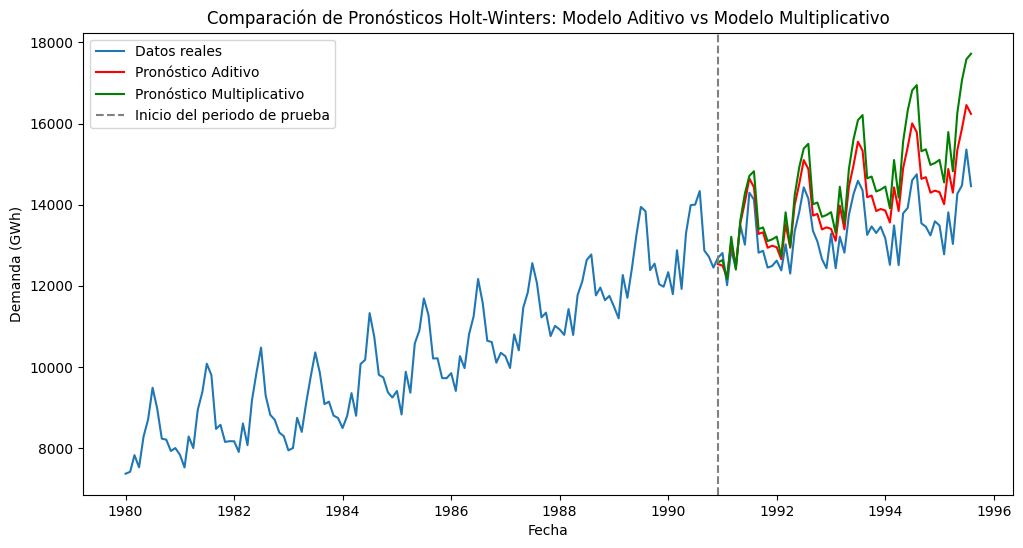

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(series2['Demanda(GWh)'], label='Datos reales')
plt.plot(forecast_add.index, forecast_add, label='Pronóstico Aditivo', color='red')
plt.plot(forecast_mul.index, forecast_mul, label='Pronóstico Multiplicativo', color='green')
plt.axvline(x=series2.index[train_size], color='gray', linestyle='--', label='Inicio del periodo de prueba')
plt.xlabel('Fecha')
plt.ylabel('Demanda (GWh)')
plt.title('Comparación de Pronósticos Holt-Winters: Modelo Aditivo vs Modelo Multiplicativo')
plt.legend()
plt.show()